# Parallelism

<img src="assets/opt_code.jpg" width="500" height="350"/>

Your CPU has **multiple cores**, but that still wouldn't mean that it would run Hogwarts Legacy at max settings, but eh, it can atleaast run code in parallel. Many codes and algorithms in astronomy can be categorized as "embarrassingly parallel", meaning that they can easily be split up into multiple tasks that each have little or no dependency on each other. An example of this is running the same image processing steps on multiple files, or computing the likelihood of a bunch of different sets of models.

<img src="assets/mordor.png" width="500" height="350"/>

Parallelilization adds extra **complexity** to the code, making it harder to debug and maintain. And you don't want that when you're already stressed about thinking what to come up to tell your advisor. Thus, it is important to consider the relative gain of implementing parallelization versus the extra effort in developing and maintaining that code. For this reason, we also recommend that you keep parallelization code as simple as possible. For many tasks, even the most simple parallelism is sufficient.

We will discuss the 2 main parallelism protocols, how to implement parallelism in Python mainly with thread/process pools and a bit about GPUs.


In [ ]:
import os
import numpy as np
import matplotlib.pylab as plt
import scipy.ndimage as ndimage
import timeit
import astropy.io.fits as fits
import random
import time
import multiprocessing as mp
%matplotlib inline

Let's see how multiprocessing code looks like before moving ahead!

In [ ]:
import multiprocessing
import numpy as np

def find_brightest_point(image):
    """Find the brightest point in a 2D numpy array representing an image."""
    y, x = np.unravel_index(np.argmax(image), image.shape)
    brightness = image[y, x]
    return x, y, brightness

if __name__ == "__main__":
    # Generate synthetic data: a list of 10 random images
    num_images = 10
    image_size = (100, 100)
    images = [np.random.random(image_size) for _ in range(num_images)]

    # Create a pool of worker processes
    pool = multiprocessing.Pool(processes=4)  # Adjust the number of processes as needed

    # Map the find_brightest_point function to the list of images
    results = pool.map(find_brightest_point, images)

    # Close the pool and wait for the work to finish
    pool.close()
    pool.join()

    # Print the results
    for i, (x, y, brightness) in enumerate(results):
        print(f"Image {i}: Brightest point at ({x}, {y}) with brightness {brightness:.2f}")


Image 0: Brightest point at (9, 85) with brightness 1.00
Image 1: Brightest point at (56, 56) with brightness 1.00
Image 2: Brightest point at (32, 93) with brightness 1.00
Image 3: Brightest point at (59, 1) with brightness 1.00
Image 4: Brightest point at (35, 30) with brightness 1.00
Image 5: Brightest point at (60, 29) with brightness 1.00
Image 6: Brightest point at (7, 99) with brightness 1.00
Image 7: Brightest point at (90, 12) with brightness 1.00
Image 8: Brightest point at (74, 25) with brightness 1.00
Image 9: Brightest point at (84, 44) with brightness 1.00


## CPUs and GPUs

<img src="assets/cpu_gpu.png" width="800" height="500"/>

- All CPUs have multiple cores, ranging from 2 to 128
    - Workhorse of scientific computing
    - Each core has multiple threads which can take on different processes in parallel (Multithreading)
    - Or you can use a whole core for one single process so that all the threads work on the same process (Multiprocessing)

- Graphics cards (GPUs) can be used for scientific computing, which have up to 16k lightweight cores
    - Very slow individually and have little cache memory
    - But perfect for large simulations and vectorized message passing
    - Difficult to program and handling CUDA exceptions is a pain in the butt
    - Need to micro-manage memory movement, parallelism, using programming language CUDA
    - When properly done, it can speed up calculations up to 50x, but in reality, it’s usually 10-20x
    - Same speed-up expectations for other many-core CPU/DPU chips, but it’s easier to program. Doesn’t require a rewrite/refactor of the code

<img src="assets/cpuvsgpu.jpeg" width="350" height="400"/>

I present to you

### THIS

 <img src="assets/Frontier.jpg" width="500" height="350">


## Running Multiple Python Instances

<img src="assets/gru.jpg"/>



> *Me think, why waste time doing GPU/CUDA/HPC, when few calls a py script do trick.*



This might sound very unsophisticated, but it sometimes is a decent choice. Python parallelism is not the best, and if tasks are completely independent of each other, running each task as a separate Python process and saving the result as a file is a perfectly reasonable (and simple) option. This is great for batch processes such as bulk processing a bunch of files with some data reduction code and is known as parameter sweep.

There are many options to do this: bash script, GNU Parallel, or, as we will focus on today, a main python script. We will focus on using a python script to launch a bunch of python processes because all capabilities of shell scripting (e.g., calling bash commands with the sys module) can be done in Python, and often with much better readability. We will use python to launch a bunch of python processes.

### Before we begin with multiprocessing, a few important points:

 * Only one process can spawn other processes. Your subprocesses cannot spawn their own subprocesses! Generally, there is always a way to program things so that only one process needs to spawn subprocesses
 * While python is generally OS-agnostic, you may run into OS specific issues with multiprocesses due to the fact it is implemented a bit differently for Linux, Mac, and Windows.
 * One key difference to remember when developing packages for multiple OSes: on Mac and Windows, any lines with multiprocessing calls need to be wrapped in something like ``if __name__ == "__main__"``, otherwise you will get an error mentioning something about `freeze_support()` when trying to run it. This is not required in Jupyter notebooks, so we have merely commented where you would need them here. The details for why this is necessary is related to subprocesses not spawning their own subprocesses and is quite technical, but [here is a related blog post if you want to learn more](https://pythonspeed.com/articles/python-multiprocessing/).

### Checking Resource Usage

Anytime you are testing parallelized code, it is good to monitor your CPU/RAM usage. Monitoring your CPU usage can help you assess if the number of processes being run in parallel is consistent with what you are looking for. Many times, running parallelized code already involves big data sets, and parallelization will use even more memory (you can think of it as trading runtime for memory usage). So have your resource monitor up occasionally when you are developing this code. It is also a great way to debug the code (e.g., identify hanging parallelization that is not finishing).

We create a function with an argument `index` that tells each process what chunk of the task to run. We then create a bunch of processes, give them their chunks, and call `start()` to run them. Afterwards, our main process uses `join()` to wait for each process to finish. It is important to always call `join()` at the end to ensure all processes have finished running! If a process has finished immediately, `join()` will immediately return; if a process has not finished, our main process will sleep until the process it is waiting on has finished.

In [ ]:
mat = np.random.random((5000, 2000)) # 5000x2000 matrix, adjust size if this takes too long or runs too quickly

def matrix_loop(mat, index):
    # divide up so that we only compute one chunk of the mat.dot(mat.T) matrix
    index_start = mat.shape[0] // 10 * index
    index_end = mat.shape[0] // 10 * (index + 1)
    val  = mat[index_start:index_end].dot(mat.T)
    print("Process {0} complete. First value is {1}".format(index, val.ravel()[0]))
    # could save value to a shared variable or save to a file to be used later

process_list = []

### The following code would need to be wrapped in `if __name__ == "__main__":` (both for loops).
for i in range(10):
    p = mp.Process(target=matrix_loop, args=(mat, i))
    process_list.append(p)
    p.start()

for p in process_list:
    p.join()

Process 2 complete. First value is 493.2811943561418
Process 0 complete. First value is 652.4701913220091
Process 1 complete. First value is 494.9447315399865
Process 4 complete. First value is 492.05800791682225
Process 3 complete. First value is 502.5242973032759
Process 5 complete. First value is 492.11378076541695Process 6 complete. First value is 504.6739418923859

Process 7 complete. First value is 496.5413670126322Process 8 complete. First value is 497.0187934781186

Process 9 complete. First value is 501.1996022206788


## 🔥 Example time! 🔥

Let's build a Monte Carlo solver that simulates radioactive decay that runs in serial (1 core) and in parallel, using Python's thread pool in the multiprocessing module.

Consider the radioactive decay of ${ }^{8} \mathrm{Li}$. This isotope of $\mathrm{Li}$ is unstable and has a relatively long half-life $\left(\tau_{1 / 2}\right)$ of $838.7(3) \mathrm{ms} .{ }^{8} \mathrm{Li}$ undergoes a $\beta^{-}$ decay and produces daughter isotope of ${ }^{8} \mathrm{Be}$. The decay rate can be described using a simple differential equation:

$$
\frac{d N}{d t}=-\lambda N
$$

where $\lambda$ is the decay rate. By integrating Equation 1, we obtain:

$$
N=N_{0} e^{-\lambda t}
$$

where $N_{0}$ is the initial number of particles. The decay rate, $\lambda$, can be rewritten in terms of the half-life: $\lambda=\ln (2) / \tau_{1 / 2}$.

Function to model the radioactive decay of ${ }^{8} \mathrm{Li}$ particles using the Metropolis algorithm. Consider a system with $N_{0}=1,000$ and model the decay up to a maximum time of 1 second.

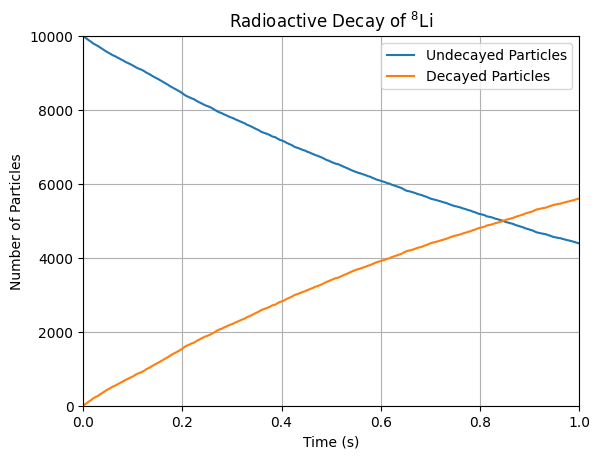

In [ ]:
# Parameters
N0 = 10000 # change this to 1000 if PC is old
num_simulations = 100 # reduce this to 10 if PC is old
half_life = 0.8387
max_time = 1
dt = 0.001

# Read more about metropolis decay algorithm here - https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/

def metropolis_decay(N0, half_life, max_time, dt):
    decay_constant = np.log(2) / half_life
    time_points = np.arange(0, max_time, dt)
    num_steps = len(time_points)
    decayed_particles = np.zeros(num_steps)
    undecayed_particles = np.ones(num_steps) * N0

    for i in range(1, num_steps):
        undecayed_previous = int(undecayed_particles[i - 1])
        decayed_previous = int(decayed_particles[i - 1])

        decay_probability = 1 - np.exp(-decay_constant * dt)

        random_numbers = np.random.rand(undecayed_previous)
        decayed_this_step = random_numbers < decay_probability # Boolean array for decayed particles

        undecayed_particles[i] = undecayed_previous - np.sum(decayed_this_step)
        decayed_particles[i] = decayed_previous + np.sum(decayed_this_step)

    return time_points, undecayed_particles, decayed_particles


time_points, undecayed_particles, decayed_particles = metropolis_decay(N0, half_life, max_time, dt)

# Plot the results
plt.plot(time_points, undecayed_particles, label='Undecayed Particles')
plt.plot(time_points, decayed_particles, label='Decayed Particles')
plt.xlabel('Time (s)')
plt.ylabel('Number of Particles')
plt.title('Radioactive Decay of $^8$Li')
plt.xlim(0, max_time)
plt.ylim(0, N0)
plt.grid()
plt.legend()
plt.show()

Total execution time for 100 serial simulations: 10.8457 seconds


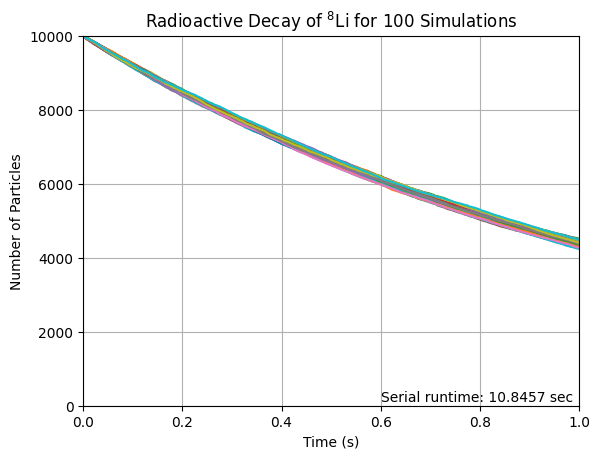

In [ ]:
#Serial decay - running 100 systems of 100000 particle decays in series

# Record execution time
start_time = time.time()

# Run simulations in serial
for _ in range(num_simulations):
    time_points, undecayed_particles, decayed_particles = metropolis_decay(N0, half_life, max_time, dt)
    plt.plot(time_points, undecayed_particles)

plt.xlabel('Time (s)')
plt.ylabel('Number of Particles')
plt.title(f'Radioactive Decay of $^8$Li for {num_simulations} Simulations')
plt.xlim(0, max_time)
plt.ylim(0, N0)
plt.grid()

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time for {num_simulations} serial simulations: {execution_time:.4f} seconds")
plt.text(0.6, 100, f'Serial runtime: {execution_time:.4f} sec')
plt.show()

Total execution time for 100 parallel simulations: 11.5840 seconds


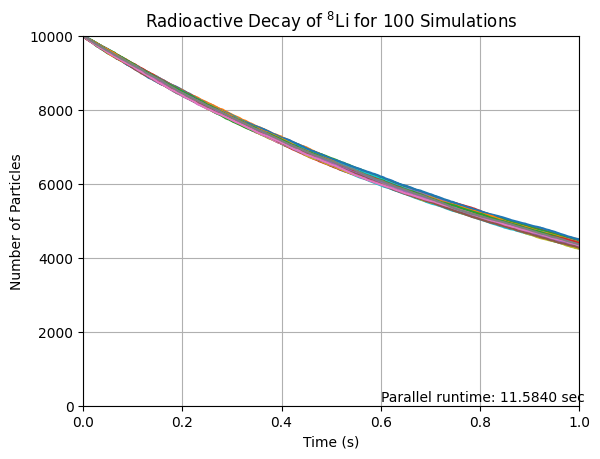

In [ ]:
#Parallel decay - running 100 systems of 100000 particle decays in parallel

# Worker function for parallel simulations
def worker(seed, N0, half_life, max_time, dt, output_dict):
    np.random.seed(seed)
    #complete the function

num_processes = os.cpu_count()

# set up simulations in parallel
manager = mp.Manager()
output_dict = manager.dict()

# Record execution time using time library


# Define Processes with a random seed for each process


# You're missing something here



all_time_points = []
all_undecayed_particles = []
all_decayed_particles = []

for seed, result in output_dict.items():
    #complete the loop

plt.xlabel('Time (s)')
plt.ylabel('Number of Particles')
plt.title(f'Radioactive Decay of $^8$Li for {num_simulations} Simulations')
plt.xlim(0, max_time)
plt.ylim(0, N0)
plt.grid()

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time for {num_simulations} parallel simulations: {execution_time:.4f} seconds")
plt.text(0.6, 100, f'Parallel runtime: {execution_time:.4f} sec')
plt.show()

### Pools

<img src="assets/multithread.jpeg" width="600" height="350"/>

Manually creating threads requires a bunch of upkeep code, which is unnecessary if you are just running over a giant loop. In the spirit of keeping parallelism simple, use a high-level parallelization API provided by your programming language whenever possible! It will save you time and effort (Trust me). For dividing up tasks with a for loop, use Python process `Pools`. Essentially, you can give
any number of tasks to a process `Pool` and the processes in the pool will loop through and do each one per your instructions.

**When in doubt about how to parallelize code, use process pools!** They are flexible and can accomodate most use cases. And since they have a standardized interface for how to use them, it will make your code more understadable by others compared to home-brewing your own parallelism.

In [ ]:
def matrix_pool(mat, index):
    # divide up so that we only compute one chunk of the mat.dot(mat.T) matrix
    index_start = mat.shape[0] // 10 * index
    index_end = mat.shape[0] // 10 * (index + 1)
    val  = mat[index_start:index_end].dot(mat.T)
    print("Job {0} complete".format(index))

    return val # let's return the data this time

In [ ]:
# Synchronous parallelization

### This entire block would need to be wrapped in `if __name__ == "__main__":`
pool = mp.Pool(processes=8) # creae a pool with 8 worker processes

pool_jobs = []
for i in range(10):
    result = pool.apply(matrix_pool, (mat, i))
    pool_jobs.append(result)
    print("Created job {0}".format(i))

for i, result in enumerate(pool_jobs):
    print("Job result {0}. First value is {1}".format(i, result.ravel()[0]))

# Close the pool and wait for the work to finish
pool.close()
pool.join()

Job 0 complete
Created job 0
Job 1 complete
Created job 1
Job 2 complete
Created job 2
Job 3 complete
Created job 3
Job 4 complete
Created job 4
Job 5 complete
Created job 5
Job 6 complete
Created job 6
Job 7 complete
Created job 7
Job 8 complete
Created job 8
Job 9 complete
Created job 9
Job result 0. First value is 652.4701913220091
Job result 1. First value is 494.9447315399865
Job result 2. First value is 493.2811943561418
Job result 3. First value is 502.5242973032759
Job result 4. First value is 492.05800791682225
Job result 5. First value is 492.11378076541695
Job result 6. First value is 504.6739418923859
Job result 7. First value is 496.5413670126322
Job result 8. First value is 497.0187934781186
Job result 9. First value is 501.1996022206788


In [ ]:
# Asynchronous parallelization

### This entire block would need to be wrapped in `if __name__ == "__main__":`
pool = mp.Pool(processes=8) # creae a pool with 8 worker processes

pool_jobs = []
for i in range(10):
    job = pool.apply_async(matrix_pool, (mat, i))
    pool_jobs.append(job)
    print("Created job {0}".format(i))

for i, job in enumerate(pool_jobs):
    result = job.get()
    print("Job result {0}. First value is {1}".format(i, result.ravel()[0]))

# Close the pool and wait for the work to finish
pool.close()
pool.join()

Created job 0
Created job 1
Created job 2
Created job 3
Created job 4
Created job 5
Created job 6
Created job 7
Created job 8
Created job 9
Job 0 complete
Job result 0. First value is 652.4701913220091
Job 1 complete
Job result 1. First value is 494.9447315399865
Job 2 complete
Job result 2. First value is 493.2811943561418
Job 3 complete
Job result 3. First value is 502.5242973032759
Job 4 complete
Job result 4. First value is 492.05800791682225
Job 5 complete
Job result 5. First value is 492.11378076541695
Job 6 complete
Job result 6. First value is 504.6739418923859
Job 7 complete
Job result 7. First value is 496.5413670126322
Job 8 complete
Job result 8. First value is 497.0187934781186
Job 9 complete
Job result 9. First value is 501.1996022206788


## Libraries, but more like protocols
#### Getting performance out of your code means
- Picking the right algorithm
- Implementing the algorithm efficiently
- We also need to understand the computer’s CPU/GPU architecture and how it works
- To exceed a single core’s performance, we must go parallel


<img src="assets/diff.png" width="700" height="300">

## OpenMP

OpenMP is a set of compiler directives and an API for C, C++, and Fortran that provides support for parallel programming in shared-memory environments. OpenMP is a portable, scalable model that gives programmers a simple and flexible interface for developing parallel applications for platforms ranging from the standard desktop computer to the supercomputer.

- Most (all?) modern compilers support OpenMP, however, the performance across them can vary. GCC does a reasonable job.
- Python enforces a “global interpreter lock” that means only one thread can talk to the interpreter at any one time. So, OpenMP within pure python is not possible.

<img src="assets/gil.jpeg" width="500" height="500"/>


> Global Interpreter Lock (GIL) - a restriction used in Python interpreter to make sure that only one thread runs Python code at a time, even on multi-core processors. The GIL protects access to Python objects to avoid issues like memory corruption when multiple threads try to modify data at the same time.


- However, C extensions or Cython code called from python can use shared-memory parallelism. That is, the underlying code can have OpenMP directives
- There will be a systemwide default for OMP_NUM_THREADS. Things will still run if you use more threads than cores available, but don’t do this, it's not good practise!
- This is called oversubscription, and will cause work to queue up. It’s better to use a maximum of 1 OpenMP thread per core
- Scaling: if you double the number of cores, does the code take ½ the time?



#### OPTIONAL

```cpp
#include <stdio.h>
void main() {
#pragma omp parallel
printf(“Hello world\n”);
}
```

You can compile this with gcc –o hello –fopenmp hello.c

```cpp
#include <stdio.h>
#ifdef _OPENMP
#include <omp.h>
#endif
void main()
{  
    int nthreads, thread_num;

#ifdef _OPENMP  
    nthreads = omp_get_num_threads();  
    thread_num = omp_get_thread_num();  
    printf("[thread %d] Outside of parallel region = %d\n", thread_num, nthreads);
#pragma omp parallel
{  
    nthreads = omp_get_num_threads();  
    thread_num = omp_get_thread_num();  
    printf("[thread %d] Inside of parallel region = %d\n", thread_num, nthreads);
}
#else  
    printf("OpenMP not enabled.\n");
#endif
}

#pragma omp parallel private(i,j,n)  
{  
    n = 0;  
    #pragma omp for  
    for (j = 0; j < N; j++) {    
        for (i = 0; i < N; i++, n++) {      
            a[n] = i + j;    
    }    
    x[j] = j;    
    b[j] = 0.0;  
}
}

// Multiply  
n = 0;
#pragma omp for  
for (j = 0; j < N; j++)
{    
    for (i = 0; i < N; i++, n++)  
        { b[i] = b[i] + a[n] * x[j];   
    }
}
```


## MPI

The Message Passing Interface (MPI) is the standard library for distributed parallel computing. Now each core cannot directly see each other’s memory. You need to manage how the work is divided and explicitly send and receive messages between MPI processes. A separate instance of your program is run on each core – these are MPI processes. Thread safety is not an issue here because each instance of the program is isolated from the others. The main idea in MPI is sending messages between processes.

No longer do we simply use comments. We need to call routines in the MPI library.

```cpp
MPI_Init(&argc, &argv);  
MPI_Comm_size(MPI_COMM_WORLD, &size);  
MPI_Comm_rank(MPI_COMM_WORLD, &rank);  

hostname[MAX_LENGTH-1] = '\0';  
gethostname(hostname, MAX_LENGTH-1);  
printf("P%04d/%04d: Hello world from %s\n", rank, size, hostname);
MPI_Finalize();
```
you can run this with mpirun –n 4 ./hello_mpi

In python, we use Open-MPI, not to be confused with OpenMP, which is an open source implementation of MPI. Things are a bit more easier with OpenMPI but it still isn't easy to implement, but if you do, your code is much faster!

More useful info - https://colab.research.google.com/drive/1yxusXcFQ9ea1bff4_q5iToMhGeQnmSwC?usp=sharing#scrollTo=zqOAtb4G4-e2



### Nbody.py

Now let's look at an example where we parallelize an N-body solver that follows the 2D dynamics of a purely gravitational system with 1000 particles of 1 KG each distributed in a sphere of radius 1 meter that is bound to collapse in on itself.

install mpi4py using pip install mpi4py

The initialization routine is only run on the root (rank-0) MPI process. What MPI collective call to use to share those data with the other MPI processes?

```python
# Given code
comm = MPI.COMM_WORLD
if comm.rank == 0:
    pos, vel = initialize(Npart)
else:
    pos, vel = None, None

pos, vel = comm.bcast((pos, vel), root=0)
```

We will parallelize the force calculation by splitting the particle position list and sending them to each core. How do we modify the routine subrange to calculate the starting and ending indices of the portion associated with each MPI process (rank).

```python
def subrange(comm):
    # Serial code
    start = 0
    end = Npart

    # Parallel code
    size = comm.Get_size()  # Total number of processes (#MPI workers)
    rank = comm.Get_rank()  # Rank of the current process (ID)
    # Distribute the particles evenly across all processes accounting for non-divisible cases
    particles_per_process = Npart // size
    remainder = Npart % size
    if rank < remainder: #non-divisible case
        start = rank * (particles_per_process + 1)
        end = start + particles_per_process + 1
    else: # divisble case
        start = rank * particles_per_process + remainder
        end = start + particles_per_process
    return start, end, end-start
```

In the calc_accel routine, each core only works on a subset of the particles, effectively parallelizing it. However, the new acceleration arrays are local to the MPI process on which they were calculated. How do we use an MPI collective call to share these results with all MPI processes and then combine these results into a single array with a shape $=(\mathrm{N}, 3)$.

```python
#code for sharing results
all_accel = np.empty([Npart, 3])
comm.Allgather([accel, MPI.DOUBLE], [all_accel, MPI.DOUBLE])
```

Running the code!

In [ ]:
!mpirun -n 1 python Nbody.py
!mpirun -n 4 python Nbody.py
!mpirun -n 8 python Nbody.py
!mpirun -n 12 --oversubscribe python Nbody.py

Now let's run the code with 1, 4, 8 and 10 cores and see how the performance scales. To help visualize, we will plot the parallel efficiency

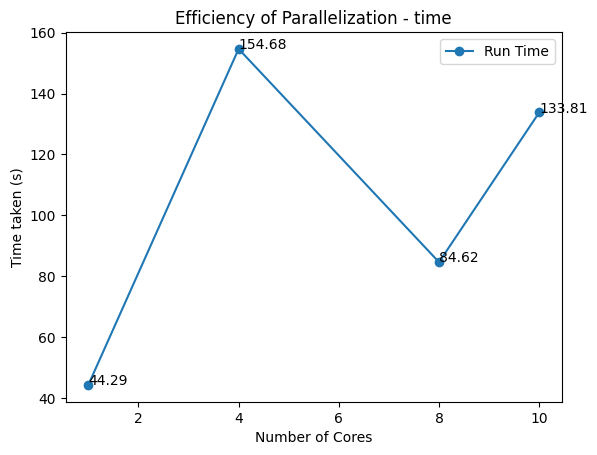

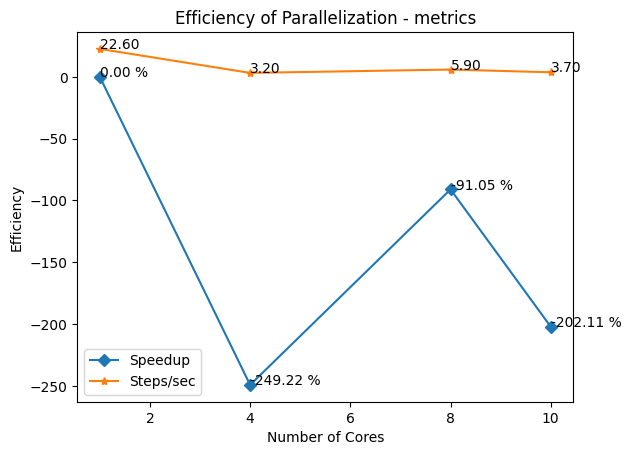

In [ ]:
# Efficiency metrics
run_time = np.array([44.292, 154.678, 84.62, 133.810])
steps = np.array([22.6, 3.2, 5.9, 3.7])
num_cores = np.array([1, 4, 8, 10])
speedup = (run_time[0] - run_time) / run_time[0] * 100

plt.figure()
plt.plot(num_cores, run_time, marker='o', label='Run Time')
for i, txt in enumerate(run_time):
    plt.annotate(f'{txt:.2f}', (num_cores[i], run_time[i]))
plt.xlabel('Number of Cores')
plt.ylabel('Time taken (s)')
plt.title('Efficiency of Parallelization - time')
plt.legend()
plt.show()

plt.figure()
plt.plot(num_cores, speedup, marker='D', label='Speedup')
plt.plot(num_cores, steps, marker='*', label='Steps/sec')
for i, txt in enumerate(speedup):
    plt.annotate(f'{txt:.2f} %', (num_cores[i], speedup[i]))
for i, txt in enumerate(steps):
    plt.annotate(f'{txt:.2f}', (num_cores[i], steps[i]))
plt.xlabel('Number of Cores')
plt.ylabel('Efficiency')
plt.title('Efficiency of Parallelization - metrics')
plt.legend()
plt.show()

We only parallelized the for-loop in the force calculation but left most of the other code untouched. From inspecting the performance increases, is it worthwhile to parallelize the other parts of the code?

## Parallel Debugging

- There are parallel debuggers, but they are usually expensive
- It’s possible to spawn multiple gdb (GNU debugger) sessions, but this gets out of hand quickly
– “mpirun -n 2 xterm -e gdb ./a.out”
- Print is still your friend - Run a small portion of a problem as possible on as few cores as necessary
- Some round off differences are to be expected from sums (different order of operation ... numeric addition is not associative)

Use this line of code to debug Nbody.py where the -np x is the number of parallel processes you want spawn

In [ ]:
!mpirun -np 2 xterm -e gdb -ex run --args python3 Nbody.py

# Parallelism Extended Cut

There is a lot of talk about in parallelism - we are just scratching the surface. The above concepts _should_ cover the majority of parallelism use cases. However, here are some good things to know.

<img src='assets/parallel_memes.png' width="500" height="650">

## Do you really need parallelism

We already emphasized this above, but parallelism adds complexity. Try avoiding parallelization until it is necessary. If some code takes 10 minutes to run, but you only need to run it once per week, is it worth parallelizing? The programming and upkeep costs may not be worth it. Parallelism also makes it hard to debug: we cannot attach the python debugger on other Python processes meaning they often crash with no error message as to why. GNU Parallel (below) is an alternative to writing more complicated code.

## GNU Parallel

If you have a script that you want to run multiple times (e.g., on multiple files), you don't need to write Python parallelization. We can use the `parallel` package that can be installed on UNIX systems to handle the parallelization. For example, if we can process a single file by running on the command line:

    python process.py file_01.fits

Then we can run it on `file_01.fits` to `file_99.fits` by running on the command line:

    parallel python process.py ::: file_{01..99}.fits


## Threads vs Processes
Python has two parallelization modules: `multiprocessing` and `multithreading`. What's the difference? Why do we only use `multiprocessing`?

Threads and processes are both tasks that your computer CPUs run in parallel. Threads share the same memory, whereas processes do not. Processes have to communicate between each other using shared variables (see below) or via a slower I/O method (writing to files, communicating over websockets). Most languages use threads to parallelize computations because sharing the same memory is very convenient and saves on resources. However, Python has the "Global Intepreter Lock" (GIL) that allows only one thread to run at a time (for complicated consistency reasons). Generally, parallelism in astronomy involves computationally intensive tasks so only one of them being able to run at a time would defeat the purpose. That's why you will generally only see multiprocessing in astronomy-related software development.



Threads are more frequently seen outside of astronomy, but it is generally useful for "I/O bound tasks" as opposed to the "CPU bound tasks" that we usually encounter in astronomy. Anytime you have tasks with a lot of sleeping/waiting time such as if you have multiple web API queries (e.g., multiple database queries) or waiting for files to be created, threads are a better choice because they use less memory and they can access all of your variables instead of having to define shared variables.

The one notable exception is that `numpy` functions that call C code releases the GIL. This means if your code is dominated by `numpy` matrix operations such as dot product, then you can actually use threads with minimal increase in runtime.

| Feature             | **Threads**                                      | **Processes**                                    |
| ---------------------------- | ------------------------------------------------ | ------------------------------------------------ |
| **Definition**               | Lightweight sub-units of a process               | Independent programs with their own memory space |
| **Memory Space**             | Shared within the same process                   | Separate for each process                        |
| **Communication**            | Fast, via shared memory                          | Slower, via Inter-Process Communication (IPC)    |
| **Isolation**                | Low (shared resources can lead to conflicts)     | High (crashes are contained to one process)      |
| **Creation Overhead**        | Low                                              | High                                             |
| **Context Switching**        | Faster (lightweight)                             | Slower (heavyweight)                             |
| **Concurrency Type**         | Better for I/O-bound tasks                       | Better for CPU-bound tasks                       |
| **Crash Impact**             | Can crash the entire process                     | Usually isolated to the crashing process         |
| **Security**                 | Less secure (shared memory risks)                | More secure (separate memory spaces)             |
| **Scalability**              | Limited by GIL in CPython                        | Can fully utilize multi-core CPUs                |
| **Startup Time**             | Faster                                           | Slower                                           |
| **Communication Complexity** | Simple (direct access to shared data)            | Complex (e.g., pipes, sockets, queues)           |


## Shared Variables

Processes do not by default share memory. For processes to read/write/access the same variables, we have to declare shared memory. Python `multiprocessing` provides nearly all shared memory structure that you should be using: queues and arrays. Queues allow for interprocess communication. Arrays allow for large datasets to be accessed by multiple processes without needing to duplicate them (possibly saving a lot of memory usage). Use these special arrays and queues becasue they are automatically synchronized between processes and do not require synchronization code, which is generally low-level synchronization that we should avoid programming unless we absolutely need it.

However, in most applications, you will find you won't need to do this at all because each task will operate on a separte chunk of data. We did not need to use it in any of the examples seen in this notebook.


<img src="assets/cluster.jpg">

# Activity: Image Processing

Run the following code to generate some fake data and then run the following image processing function on each fake image and save the resulting data. How fast can you process the data when the images are 1000x1000? What is the speedup from 1 core to multiple cores (is it linear?)?

### Instructions

  * Run the first cell below to generate 25 images of fake data
  * Run the second cell below to run the `process_image()` function on a single image without parallelism. Time how long this takes. Let's call this time t0.
  * Write parallelization code to parallelize the `process_image()` function to process all 25 images. Time how long it takes to process 25 images. Let's call this tp.
  * Compute speedup = (25 * t0) / tp: the speedup factor between doing 25 images in series and parallelizing it.
  * (Optional) Try using different number of processes to parallelize the activity. How does the run time change with the number of processes used? How does it relate to the number of cores you have on your computer? Is it linear?

### End Product
  * Report on Piazza your best speedup factor you got. And specify how many processes you used, and how many cores you have.
  * (Optional): make a graph of wall clock time to process 25 images vs number of processes used. Post this on Piazza as well.  

### Roles
  * Driver: in charge of sharing their screen and typing the code for this activity
  * Recorder: in charge of writing down all the results and reporting back when we poll everyone
  * Navigator: in charge of directing the driver what to code (everyone else; can be more than one person)

In [ ]:
# note, this cell might take a minute to run.

def generate_fake_data(filename, dims):
    """
    Generates a fake dataframe with random numbers

    Args:
        filename (str): file to save the data to
        dims (tuple): (Ny, Nx) pair that species the size of the y and x dimensions
    """
    # some complicated random image generation. Feel free to ignore.
    # coordinate system in fourier spae
    u,v = np.meshgrid(np.fft.fftfreq(dims[1]), np.fft.fftfreq(dims[0]))
    phases = np.random.uniform(0, 2*np.pi, u.shape)
    rho = np.sqrt((u*dims[1])**2 + (v*dims[0])**2)
    # suppress high frequency by a squared exponential
    spectrum = np.exp(-rho**2/(np.max(rho)/50)**2)  * np.exp(1j * phases)
    filtered = np.real(np.fft.ifft2(spectrum))

    fits.writeto(filename, filtered, overwrite=True)


# generate fake data (can choose to save it somethere else if you want)
fileformat = os.path.join("./", "fake_{0}x{1}_{2}.fits")

ny = 1000
nx = 1000
for i in range(25):
    filename = fileformat.format(ny, nx, i)
    generate_fake_data(filename, (ny, nx) )


In [ ]:
def process_image(frame, filtersize=50):
    """
    Run a high-pass filter on the data.
    Remove the low spatial frequency (i.e., smooth features) in the image

    Args:
        frame (np.array): a 2-D image to be processed
        fitersize (int): the size of the filter. Features smaller than the filtersize will be preserved

    Returns:
        processed_frame (np.array): a 2-D image after processing
    """
    # run a median filter to smooth the image
    frame_smooth = ndimage.median_filter(frame, filtersize)

    processed_frame = frame - frame_smooth

    return processed_frame

# an example of running this on one image
with fits.open(fileformat.format(ny, nx, 0)) as hdulist:
    data = hdulist[0].data


    filt_data = process_image(data)

    fig = plt.figure(figsize=(6,3))
    ax1 = fig.add_subplot(121)
    ax1.imshow(data, cmap="inferno")
    ax1.set_title("Original")
    ax2 = fig.add_subplot(122)
    ax2.imshow(filt_data, cmap="inferno")
    ax2.set_title("Filtered")

#### Activity:
# write and time some code that runs this on all 25 images in parallel. How does the performance increase
# as you increase the number of processes you use?
# we recommend you use multiprocessing pool for this task



---


#**OPTIONAL ->**

## Hybrid parallelism (Optional)

<img src="assets/mix.png"/>

- To get good performance on current HPC platforms (>1k cores), you need to use hybrid parallelism
- OpenMP within a node / socket, MPI across nodes
- For example, let's assume a huge 4x4x4 cube where you need to perform computations within a cube and across the cubes - accretion disk simulation and boundary condition passing
- Then we have MPI to communicate across cubes and OpenMP within the cubes
- The hybrid approach is often needed to get the best performance on big machines

## GPU parallelization (Optional)

<img src="assets/gpu_para.png" width="400" height="350">

- GPU offloading can greatly accelerate computing
- Main issue: data needs to be transferred from the CPU/RAM across the PCIe bus (relatively slow) to the GPU
- GPUs work as SIMD parallel machines (vectorized)
    - The same instructions operate on all the data in lockstep
    - Branching (if-statements) is slower
- Best performance requires that you structure the code to be vectorized
- CUDA is popular but is not portable to non-nVidia GPUs and accelerators
- but OpenMP supports offloading to GPUs

## (Optional) Flynn’s taxonomy classifies computer architectures as single or multiple data; single or multiple instruction

- Single instruction, single data (SISD)
    - Typical application on your computer – no parallelism
- Single instruction, multiple data (SIMD)
    - The same instruction set is done to multiple pieces of data all at once
    - Compile-time vectorization optimization; GPUs
- Multiple instructions, single data (MISD)
    - Not very interesting or useful
- Multiple instructions, multiple data (MIMD)
    - This is what we classify as parallel computing


